<a href="https://colab.research.google.com/github/SLCFLAB/Fintech2024-2/blob/main/DL_day9/9_2_RNN_and_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Prediction with Deep Learning Models

You will now practice using deep learning models(RNN, LSTM) to predict future values using past values. For your assignment, please change parameters, model structures and apply new model to shampoo data.

Reference:
* https://github.com/hee9joon/Univariate-Time-Series-Prediction-using-Deep-Learning.   
*  https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb

# Time Series Prediction with LSTM Using PyTorch

This kernel is based on *datasets* from

[Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)


## Download Dataset

In [1]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv

--2024-08-27 18:32:03--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519 [text/plain]
Saving to: ‘shampoo.csv.3’

shampoo.csv.3       100%[===================>]     519  --.-KB/s    in 0s      

2024-08-27 18:32:03 (37.2 MB/s) - ‘shampoo.csv.3’ saved [519/519]



In [2]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2024-08-27 18:32:04--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv.3’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2024-08-27 18:32:04 (49.6 MB/s) - ‘airline-passengers.csv.3’ saved [2180/2180]



## Library

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler

## Data Plot

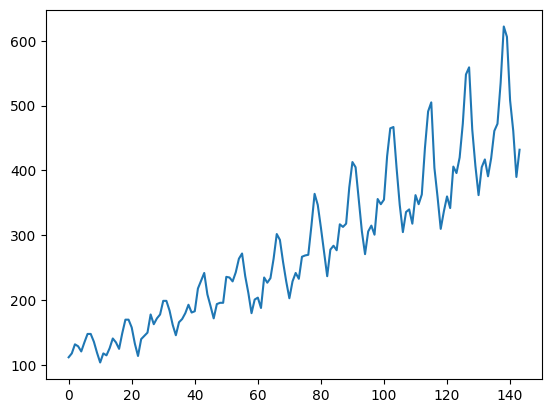

In [50]:
training_set = pd.read_csv('airline-passengers.csv')
#training_set = pd.read_csv('shampoo.csv')

training_set = training_set.iloc[:,1:2].values

#plt.plot(training_set, label = 'Shampoo Sales Data')
plt.plot(training_set, label = 'Airline Passangers Data')
plt.show()

## Dataloading

In [52]:
sc = StandardScaler()
seq_length = 4

test_size = 20
train_size = len(training_set) - seq_length - 20

train_data = sc.fit_transform(training_set[:-test_size])
test_data = sc.transform(training_set[-test_size:])

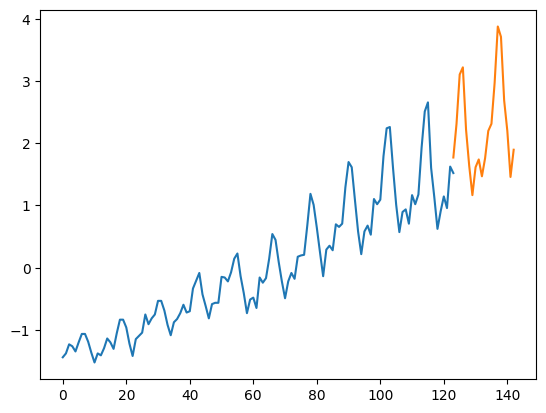

In [53]:
plt.plot(np.arange(124),train_data)
plt.plot(np.arange(20)+123,test_data)

In [54]:
def sliding_windows(data, seq_length):
    x = []
    y = []
    for i in range(len(data)-seq_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [55]:
normalized_data = np.concatenate([train_data, test_data])
x, y = sliding_windows(normalized_data, seq_length)

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[:-test_size])))
trainY = Variable(torch.Tensor(np.array(y[:-test_size])))

testX = Variable(torch.Tensor(np.array(x[-test_size:])))
testY = Variable(torch.Tensor(np.array(y[-test_size:])))

## Model

In [56]:
class RNN(nn.Module):
    # Vanilla RNN
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):

        batch_size = x.size(0)

        # initialize hidden state for first input
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)

        # pass model input and hidden state
        h_out, hidden = self.rnn(x, hidden.detach())

        h_out = h_out[:,-1,:]
        #h_out = h_out.contiguous().view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

In [92]:
class LSTM(nn.Module):
    # Long Short Term Memory
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):

        #mean = x.mean(dim=1,keepdim=True)
        #std = x.std(dim=1,keepdim=True)
        #x = (x-mean)/std

        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)

        #out = out*std[:,0,:]+mean[:,0,:]

        return out

## Training

In [90]:
num_epochs = 5000
learning_rate = 0.001

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

best_loss = 10
best_model = None

model = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = model(trainX)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)

    loss.backward()

    optimizer.step()
    if epoch % 50 == 0:
      model.eval()
      outputs = model(testX)
      loss = criterion(outputs, testY)
      model.train()
      if loss.item()<best_loss:
        best_loss = loss.item()
        best_model = model
      if epoch % 500 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.89037
Epoch: 500, loss: 0.37923
Epoch: 1000, loss: 0.28410
Epoch: 1500, loss: 0.25988
Epoch: 2000, loss: 0.25842
Epoch: 2500, loss: 0.18253
Epoch: 3000, loss: 0.15828
Epoch: 3500, loss: 0.15986
Epoch: 4000, loss: 0.15630
Epoch: 4500, loss: 0.15643


## To-Do
Write code for training LSTM model

## Testing for Airplane Passengers Dataset

Best Loss: 0.15551325678825378


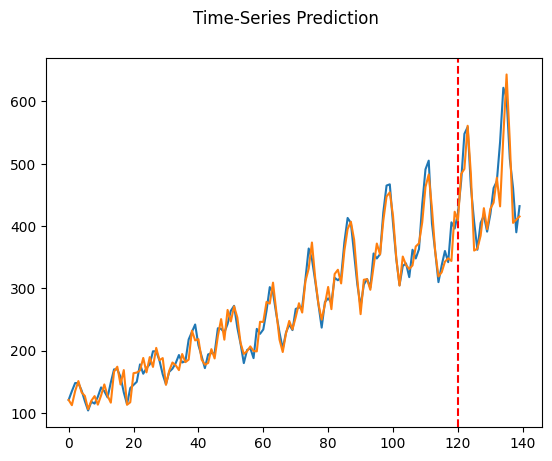

In [91]:
best_model.eval()
train_predict = best_model(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

print("Best Loss: {}".format(best_loss))

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

## To-do

Test your Vanilla RNN models